# Neural model of hierarchy embedding

In [1]:
# Setup the environment 

import nengo
import nengo_gui
import nengo.spa as spa
from nengo.spa import Vocabulary
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_context("paper")
rc={'xtick.labelsize': 11, 'ytick.labelsize': 11}
sns.set(rc=rc)
sns.set_style(style='whitegrid')

In [ ]:
# Construct the embeddings using HRRs

dim = 64
rng = np.random.RandomState(26)
vocab = Vocabulary(dimensions=dim, rng=rng, max_similarity=0.05, unitary=True)

incr = vocab.parse("INCREMENT")
zero = vocab.parse("ZERO")
sex = vocab.parse("SEX")

vocab.add("ONE", vocab.parse("ZERO*INCREMENT+SEX*MALE+B"))
vocab.add("SIX", vocab.parse("ZERO*INCREMENT+SEX*FEMALE+G"))

vocab.add("TWO", vocab.parse("ONE*INCREMENT+SEX*MALE+C"))
vocab.add("SEVEN", vocab.parse("ONE*INCREMENT+SEX*FEMALE+H"))

vocab.add("THREE", vocab.parse("TWO*INCREMENT+SEX*FEMALE+D"))
vocab.add("FOUR", vocab.parse("THREE*INCREMENT+SEX*MALE+E"))
vocab.add("FIVE", vocab.parse("FOUR*INCREMENT+SEX*FEMALE+F"))

vocab.add("EIGHT", vocab.parse("SEVEN*INCREMENT+SEX*FEMALE+I"))
vocab.add("TEN", vocab.parse("EIGHT*INCREMENT+SEX*MALE+K"))

vocab.add("NINE", vocab.parse("SEVEN*INCREMENT+SEX*MALE+J"))
vocab.add("ELEVEN", vocab.parse("NINE*INCREMENT+SEX*MALE+L"))

vocab.add("TWELVE", vocab.parse("SIX*INCREMENT+SEX*MALE+M"))
vocab.add("THIRTEEN", vocab.parse("SIX*INCREMENT+SEX*FEMALE+N"))

# create sub vocabs
par_vocab = vocab.create_subset(['MALE', 'FEMALE'])
num_vocab = vocab.create_subset(['ZERO', 'ONE', 'TWO', 'THREE', 'FOUR', 'FIVE', 'SIX', 
                               'SEVEN', 'EIGHT', 'NINE', 'TEN', 'ELEVEN', 'TWELVE', 'THIRTEEN'])

In [3]:
# Build the neural model

model = spa.SPA() 
with model:
    model.a = spa.State(dim, vocab=vocab, label="A")
    model.b = spa.State(dim, vocab=vocab, label="B")
    model.trans = spa.State(dim, vocab=vocab, feedback=1, label="transformation")
    
    model.cue1 = spa.State(dim, vocab=vocab)
    model.cue2 = spa.State(dim, vocab=vocab)
    
    model.succ = spa.State(dim, vocab=vocab)
    model.pred = spa.State(dim, vocab=vocab)
    model.assoc_memSucc = spa.AssociativeMemory(input_vocab=vocab, threshold=2.0, threshold_output=True, label="succ_cleanup")
    model.assoc_memPred = spa.AssociativeMemory(input_vocab=vocab, wta_output=True, threshold_output=True, label="pred_cleanup")
    model.parity1 = spa.State(dim, vocab=vocab, label="succ_property")
    model.parity2 = spa.State(dim, vocab=vocab, label="pred_property")
    
    actions = spa.Actions(
        'trans = ~a * b',
        'succ = trans*cue1',
        'pred = ~trans*cue1',
        'assoc_memSucc = succ',
        'assoc_memPred = pred',
        'parity1 = ~cue2*assoc_memSucc',
        'parity2 = ~cue2*assoc_memPred',
    )

    model.cortical = spa.Cortical(actions)
    
    par1_probe = nengo.Probe(model.parity1.output, synapse=0.03)
    cue1_probe = nengo.Probe(model.cue1.output, synapse=0.03)
    
    par2_probe = nengo.Probe(model.parity2.output, synapse=0.03)
    cue2_probe = nengo.Probe(model.cue2.output, synapse=0.03)
    
    succ_probe = nengo.Probe(model.succ.output, synapse=0.03)
    pred_probe = nengo.Probe(model.pred.output, synapse=0.03)
    
    amsucc_inprobe = nengo.Probe(model.assoc_memSucc.input)
    amsucc_outprobe = nengo.Probe(model.assoc_memSucc.output, synapse=0.03)
    
    ampred_inprobe = nengo.Probe(model.assoc_memPred.input)
    ampred_outprobe = nengo.Probe(model.assoc_memPred.output, synapse=0.03)

In [4]:
# Define model inputs for training and cueing

def inp1(t):
    if t <= 0.2:
        return 'ZERO'                               
    elif (0.2 < t<=0.4):      
        return 'ONE'
    elif (0.4 < t<=0.6):      
        return 'ZERO' 
    else:
        return '0'
 
            
def inp2(t):
    if t <= 0.2:
        return 'ONE'                                
    elif (0.2 < t<=0.4):      
        return 'TWO'
    elif (0.4 < t<=0.6):      
        return 'SIX'
    else:
        return '0'
 
    
def cue1_inp(t):
    if 0.6 < t <= 0.8:
        return 'SEVEN'
    else:
        return '0'

    
def cue2_inp(t):
    if 0.6 < t <= 0.8:
        return 'SEX'
    else:
        return '0'
    
    
with model:
    model.input = spa.Input(a=inp1, b=inp2, cue1=cue1_inp, cue2=cue2_inp)     # provide sensory input which determines cortex state

In [ ]:
# simulate and run the model
sim = nengo.Simulator(model)
sim.run(1.5)
t = sim.trange()

In [5]:
# function for plotting similarities
# normalize = True to compute cosine similarity
def plot_similarities(idx, label, input_data,
                      output_data,
                      vocab1,
                      vocab2=None,
                      autoscale=False):
    if vocab2 is None:
        vocab2 = vocab1

    ymin, ymax = -1.2, 1.2
    #plt.figure(figsize=(8, 4))
    plt.subplot(1, 4, idx[0])
    plt.ylim(ymin, ymax)
    if autoscale:
        plt.autoscale(autoscale, axis='y')
    plt.grid(True)
    plt.plot(t, spa.similarity(input_data, vocab1, normalize=True))
    plt.title(label + " input", fontsize=15)
    plt.ylabel("cosine similarity", fontsize=15)
    plt.xlabel("Time", fontsize=15)
    plt.xlim(right=t[-1])
    #plt.legend(
        #vocab1.keys, loc='upper center', bbox_to_anchor=(0.5, -0.13), ncol=3)

    plt.subplot(1, 4, idx[1])
    plt.plot(t, spa.similarity(output_data, vocab2, normalize=True))
    plt.title(label + " output", fontsize=15)
    plt.ylabel("cosine similarity", fontsize=15)
    plt.xlabel("Time", fontsize=15)
    plt.xlim(right=t[-1])
    plt.ylim(ymin, ymax)
    if autoscale:
        plt.autoscale(autoscale, axis='y')
    plt.grid(True)
    #plt.legend(
        #vocab2.keys, loc='upper center', bbox_to_anchor=(0.5, -0.13), ncol=3)
    plt.tight_layout()   

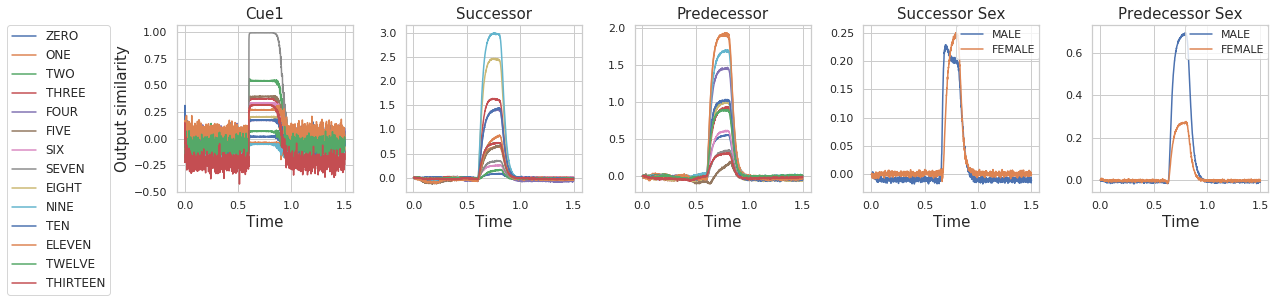

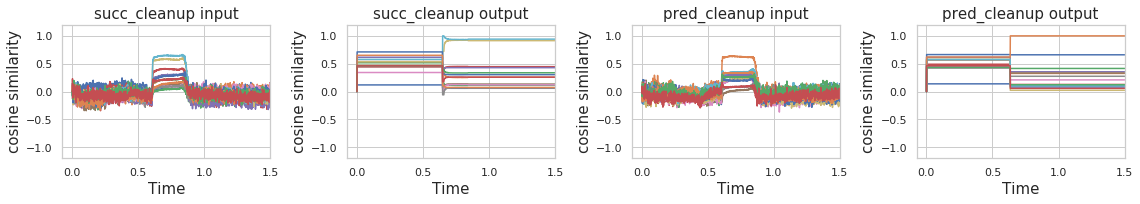

In [8]:
# Plot results

# Cue
plt.figure(figsize=(18,4))
plt.subplot(1,5,1)
plt.plot(sim.trange(), spa.similarity(sim.data[cue1_probe], num_vocab, normalize=True))
plt.xlabel("Time", fontsize=15)
plt.ylabel("Output similarity", fontsize=15)
plt.title("Cue1", fontsize=15)
plt.legend(num_vocab.keys, loc='best', bbox_to_anchor=(-0.38, 1), borderaxespad=0.0, fontsize=12);

# Successor
plt.subplot(1,5,2)
plt.plot(sim.trange(), spa.similarity(sim.data[succ_probe], num_vocab))
plt.xlabel("Time", fontsize=15)
#plt.ylabel("Output similarity", fontsize=15)
plt.title("Successor", fontsize=15)
#plt.legend(num_vocab.keys, loc='best', bbox_to_anchor=(1.05, 1), borderaxespad=0.0);

# Predecessor
plt.subplot(1,5,3)
plt.plot(sim.trange(), spa.similarity(sim.data[pred_probe], num_vocab))
plt.xlabel("Time", fontsize=15)
#plt.ylabel("Output similarity", fontsize=15)
plt.title("Predecessor", fontsize=15)
#plt.legend(num_vocab.keys, loc='best', bbox_to_anchor=(1.05, 1), borderaxespad=0.0);
plt.tight_layout() 

# Parity
#plt.figure(figsize=(6,3))
plt.subplot(1,5,4)
plt.plot(sim.trange(), spa.similarity(sim.data[par1_probe], par_vocab))
plt.xlabel("Time", fontsize=15)
#plt.ylabel("Output similarity", fontsize=15)
plt.title("Successor Sex", fontsize=15)
plt.legend(par_vocab.keys, loc='upper right', borderaxespad=0.0);

plt.subplot(1,5,5)
plt.plot(sim.trange(), spa.similarity(sim.data[par2_probe], par_vocab))
plt.xlabel("Time", fontsize=15)
#plt.ylabel("Output similarity", fontsize=15)
plt.title("Predecessor Sex", fontsize=15)
plt.legend(par_vocab.keys, loc='upper right', borderaxespad=0.0);
plt.tight_layout() 

# save results
plt.savefig('malfem_res.pdf', bbox_inches='tight', dpi=300)


# Associative memory plots
plt.figure(figsize=(16,3))
plot_similarities([1,2], "succ_cleanup", sim.data[amsucc_inprobe], sim.data[amsucc_outprobe], num_vocab)
plot_similarities([3,4], "pred_cleanup", sim.data[ampred_inprobe], sim.data[ampred_outprobe], num_vocab)
plt.tight_layout() 

plt.savefig('malfem_cleanup.pdf', bbox_inches='tight', dpi=300)

In [ ]:
# Model in nengo GUI
from nengo_gui.ipython import IPythonViz
IPythonViz(model)

In [37]:
# Total number of neurons in the model
model.n_neurons

170100